In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection, ensemble, inspection, svm, tree
)
import missingno as msno
from sklearn.preprocessing import OrdinalEncoder
import re
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## Abstract

Bank fraud is the use of potentially illegal means to obtain money, assets, or other property owned or held by a financial institution. Bank fraud is a criminal offence. While it is easy to define bank fraud, it is significantly harder to detect when it occurs, and with potentially billions of dollars that can be obtained by committing bank fraud, it is very important to be able to accurately identify when it has occured (a skill that banks would find very valuable).

Therefore in this analysis, we aim to find the set of features which best predict whether or not bank fraud has occured. To do this, we will use a variety of Machine Learning models, including Logistic Regression, Logistic Regression with the L1 penalty, and an Isolation Forest.

## The Dataset

The Bank Account Fraud (BAF) dataset has been published by FeedzAI Research. It represents a synthetic, feature-engineered bank account opening application in tabular format. It was generated using a CTGAN (a GAN-based method) trained on a real-world anonymized dataset for bank account opening fraud. There are no different types of instances.

The BAF dataset aims to be realistic, complete, and robust based on a present-day real-world dataset for fraud detection.

The dataset is composed of:

1 million instances (rows);
32 realistic features;

For more information on how the dataset was generated, please see the datasheet <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) and NeurIPS 2022 paper <a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2).

<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) https://github.com/feedzai/bank-account-fraud/blob/main/documents/datasheet.pdf

<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2) Sérgio Jesus, José Pombal, Duarte Alves, André Cruz, et al. (2022). "Turning the Tables: Biased, Imbalanced, Dynamic Tabular Datasets for ML Evaluation". https://doi.org/10.48550/arXiv.2211.13358 arXiv:2211.13358

In [2]:
dforig = pd.read_csv('Base.csv')
dforig

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,1,0.9,0.166828,-1,88,50,0.020925,-1.331345,AA,769,...,0,500.0,0,INTERNET,3.888115,windows,0,1,0,7
1,1,0.9,0.296286,-1,144,50,0.005418,-0.816224,AB,366,...,0,1500.0,0,INTERNET,31.798819,windows,0,1,0,7
2,1,0.9,0.044985,-1,132,40,3.108549,-0.755728,AC,870,...,0,200.0,0,INTERNET,4.728705,other,0,1,0,7
3,1,0.9,0.159511,-1,22,50,0.019079,-1.205124,AB,810,...,1,200.0,0,INTERNET,2.047904,linux,0,1,0,7
4,1,0.9,0.596414,-1,218,50,0.004441,-0.773276,AB,890,...,0,1500.0,0,INTERNET,3.775225,macintosh,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.6,0.192631,-1,104,40,0.030592,-1.044454,AB,804,...,0,200.0,0,INTERNET,8.511502,linux,1,1,0,4
999996,0,0.8,0.322989,148,9,50,1.628119,-1.409803,AC,3306,...,0,200.0,0,INTERNET,8.967865,windows,0,1,0,4
999997,0,0.8,0.879403,-1,30,20,0.018563,34.692760,AA,1522,...,0,200.0,0,INTERNET,8.195531,other,0,1,0,4
999998,0,0.9,0.762112,-1,189,20,0.015352,94.661055,AA,1418,...,0,500.0,0,INTERNET,4.336064,windows,1,1,0,4


## Missing Values

The columns that contain a large amount of missing values (at least 25%), which are usually represented as -1 entries (as documented on the Bank Fraud dataset <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)), can be removed. Note that missing values are -1, and not NaN for this dataset. Although median or regression imputation methods could be used to estimate these missing values, the estimates would not be useful; they would be biased and inaccurate, simply because so much of the data is missing.

For columns with less than 25% of data missing, median imputation can be used.

<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)
https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022?resource=download&select=Base.csv

In [3]:
print(dforig.isnull().any(axis = 0))  #
for i in range(32):
    print(dforig.columns[i] + " " + str(sum(dforig[dforig.columns[i]] == -1)/len(dforig)))

fraud_bool                          False
income                              False
name_email_similarity               False
prev_address_months_count           False
current_address_months_count        False
customer_age                        False
days_since_request                  False
intended_balcon_amount              False
payment_type                        False
zip_count_4w                        False
velocity_6h                         False
velocity_24h                        False
velocity_4w                         False
bank_branch_count_8w                False
date_of_birth_distinct_emails_4w    False
employment_status                   False
credit_risk_score                   False
email_is_free                       False
housing_status                      False
phone_home_valid                    False
phone_mobile_valid                  False
bank_months_count                   False
has_other_cards                     False
proposed_credit_limit             

## Dropping Variables and Median Imputation

Out of the 32 variables (31 covariates and 1 response variable), prev_address_months_count and bank_months_count have at least 25% of data missing, therefore they are removed. Further justification for the removal of these variables is that,

- The Number of months in previous registered address of the applicant, and
- How old the previous account is (if held) in months,

are intuitively variables that would not have the greatest impact on predicting fraud occurence.

The dataset has the following cateogrical predictors; 

- housing_status
- employment_status
- payment_type
- source
- device_os

For housing_status, employment_status and payment_type, the outcomes are anonymized. These features would likely yield important predictive power, i.e. employment_status and housing_status are indicators of how well off an individual may be financially, and therefore are likely to have an impact on whether fraud occurs. However, given that the data is anonymized, interpretting the coefficients would not yield important information. Therefore, we decided to drop these columns. Further justification is that the dataset has 30 columns (after removing prev_address_months_count and bank_months_count), which is a lot of covariates to regress on; in other words there is fairly high dimensionality. housing_status and employment_status have 7 categories each, while payment_type has 5 categories. In order to include the categorical predictors, we would have to use one-hot encoding, which would create one extra dimension per category (we cannot use label encoding, which would let us have only 1 column, as the variables are nominal and not ordinal). Therefore, in order to avoid increasing the dimensionality by over 15 dimensions, these variables can be dropped.

The feature "source" is also not a very useful feature as 99% of observations are via browser and only 1% are through mobile app. With such an imbalanced class, we decided that it is simply not worth incorporating source for data analysis, and thus it was also dropped.

We felt that device_os would intuitively have predictive power; fraud occurences could be linked to the type of operating system that is used, due to the ease that one operating system may provide over others. Hence, device_os was encoded and processed for further analysis.

Furthermore, for current_address_months_count, session_length_in_minutes, and device_distinct_emails_8w, there are missing values which can be imputed using the respective column medians, as shown below.

In [4]:
df = dforig.copy()
df = df.drop(columns=["prev_address_months_count", "bank_months_count", "housing_status", "employment_status",
                         "payment_type", "source"], axis = 1)

df[['current_address_months_count',
    'session_length_in_minutes', 
    'device_distinct_emails_8w']] = df[['current_address_months_count',
                                        'session_length_in_minutes', 
                                        'device_distinct_emails_8w']].replace(-1, df.median())

encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(df[['device_os']]).toarray())
encoder_df.columns = ["linux", "macintosh", "other", "windows", "x11"]
df = df.join(encoder_df)
df = df.drop('device_os', axis = 1)

for i in range(25):
    print(df.columns[i] + " " + str(sum(df[df.columns[i]] == -1)/len(df)))

fraud_bool 0.0
income 0.0
name_email_similarity 0.0
current_address_months_count 0.0
customer_age 0.0
days_since_request 0.0
intended_balcon_amount 0.0
zip_count_4w 0.0
velocity_6h 0.0
velocity_24h 0.0
velocity_4w 0.0
bank_branch_count_8w 0.0
date_of_birth_distinct_emails_4w 0.0
credit_risk_score 0.000488
email_is_free 0.0
phone_home_valid 0.0
phone_mobile_valid 0.0
has_other_cards 0.0
proposed_credit_limit 0.0
foreign_request 0.0
session_length_in_minutes 0.0
keep_alive_session 0.0
device_distinct_emails_8w 0.0
device_fraud_count 0.0
month 0.0


Note: credit_risk_score is defined as the internal score of application risk, and it ranges between [−176, 387]. Hence, having -1's for credit_risk_score is not an issue, and no imputation is required.

11029 occurences of fraud
988971 occurences of not fraud


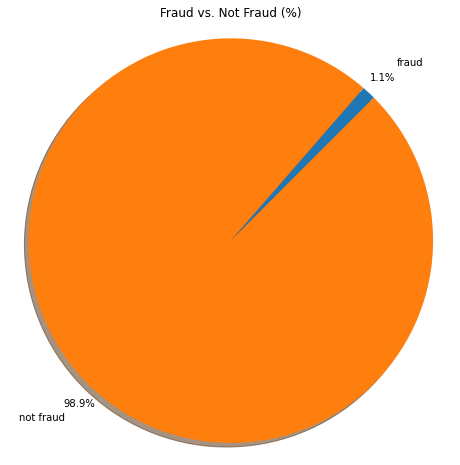

In [5]:
total_fraud = df[df["fraud_bool"] == 1]
total_not_fraud = df[df["fraud_bool"] == 0]

F = len(total_fraud.index)
NF = len(total_not_fraud.index)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:

labels = "fraud", "not fraud"
sizes = [F, NF]

fig, ax = plt.subplots(figsize = (8,8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45, pctdistance=1.1, labeldistance=1.2)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set(title = 'Fraud vs. Not Fraud (%)')

print(str(F) + " occurences of fraud")
print(str(NF) + " occurences of not fraud")

plt.show()

## Dropping More Columns

When there is collinearity between multiple variables, all but one of them can be removed. Based on the plot above, we have collinearity between the following:

- proposed_credit_limit, credit_risk_score
- velocity_6h, velocity_24h, velocity_4w
- customer_age, date_of_birth_distinct_emails_4w

Note that multicollinearity is more of an issue when predicting a continuous variable, as opposed to a categorical one (which fraud_bool is). Although addressing multicollinearity was not absolutely necessary, it is still good practice, as having multiple covariates telling the same story is redundant.

Hence, we have decided to remove:

- proposed_credit_limit
- velocity_24h, velocity_4w
- date_of_birth_distinct_emails_4w

In [6]:
df = df.drop(columns=["proposed_credit_limit", "velocity_24h", "velocity_4w", "date_of_birth_distinct_emails_4w"], 
             axis = 1)
#df_sample = df_sample.drop(columns=["proposed_credit_limit", "velocity_24h", "velocity_4w", "date_of_birth_distinct_emails_4w"], 
 #            axis = 1)

## Dealing with Imbalanced Classes

Note that the dataset is heavily imbalanced: there are far more cases of "not fraud" (legit, 98.9%) compared to fraud (1.1%). While this is quite representative of real life - in real world datasets the number of fraud cases would also be extremely small relative to not fraud - it poses a practical challenge; if the data scientists simply predict not fraud every time, the model would be 98.9% accurate, however this would of course be redundant.

Therefore, under-sampling is used. Under-sampling is a technique that deals with imbalanced classes by reducing the size of the abundant class (not fraud). This method is used when the quantity of data is sufficient, which is true (there are 1,000,000 rows, with 11,029 being fraud and 988,971 being not fraud). By keeping all samples in the rare class and randomly selecting an equal number of samples in the abundant class, a balanced new dataset can be retreived for further modelling (as shown in the code below).

In [7]:
df_fraud = df[df["fraud_bool"] == 1]
df_notfraud = df[df["fraud_bool"] == 0]
#print(df_fraud)

import random

random.seed(323)

indfr = df.index[df["fraud_bool"] == 1].to_list()
indnofr = df.index[df["fraud_bool"] == 0].to_list()
frsample = random.sample(indfr, 8000)
nofrsample = random.sample(indnofr, 8000)

df_fraudsample = df.loc[frsample]
df_notfraudsample = df.loc[nofrsample]

combsample = frsample + nofrsample
df_test = df.loc[~df.index.isin(combsample)]
# Need to shuffle for later cross validation
df_sample = pd.concat([df_fraudsample, df_notfraudsample])
#print(df_sample)
df_sample = df_sample.sample(frac=1, random_state=20)
df_sample = df_sample.reset_index(drop = True)
df_sample

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,bank_branch_count_8w,...,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,linux,macintosh,other,windows,x11
0,0,0.9,0.145914,147,20,0.012820,52.178559,1031,3529.381113,8,...,5.187277,1,1,0,4,0.0,0.0,0.0,1.0,0.0
1,0,0.4,0.126605,308,30,0.022000,11.731128,4372,8686.290260,7,...,3.134570,1,1,0,1,0.0,0.0,0.0,1.0,0.0
2,1,0.4,0.179754,193,50,0.011211,49.831108,924,2997.236933,1501,...,9.402931,0,1,0,6,0.0,0.0,0.0,0.0,1.0
3,0,0.6,0.162091,27,10,0.030261,-1.393112,704,2171.840603,0,...,7.473998,0,1,0,5,0.0,0.0,1.0,0.0,0.0
4,1,0.2,0.483981,105,40,0.002873,-1.184679,2946,4629.474518,10,...,5.954732,0,1,0,2,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,1,0.1,0.156221,48,30,0.002660,-0.439315,1099,3010.498696,5,...,5.720884,0,1,0,6,0.0,0.0,0.0,1.0,0.0
15996,1,0.9,0.817475,209,40,0.003585,-0.344389,2376,1364.529496,12,...,11.185189,0,1,0,6,0.0,0.0,0.0,1.0,0.0
15997,1,0.8,0.876376,167,50,0.000893,-0.890902,776,3059.027109,180,...,5.839261,0,0,0,2,0.0,0.0,0.0,1.0,0.0
15998,0,0.5,0.648778,397,20,0.006073,30.771639,1269,7768.507278,13,...,4.877416,1,1,0,0,0.0,0.0,1.0,0.0,0.0


## Multicollinearity

Multicollinearity, the condition in which the independent variables are correlated to each other, is a problem that needs to be addressed before training the data on models. It reduces the precision of the estimated coefficients, which weakens the statistical power of the regression models. Therefore, we have generated a correlation matrix heatmap below that makes it easy to figure out where multicollinearity may occur in our data.

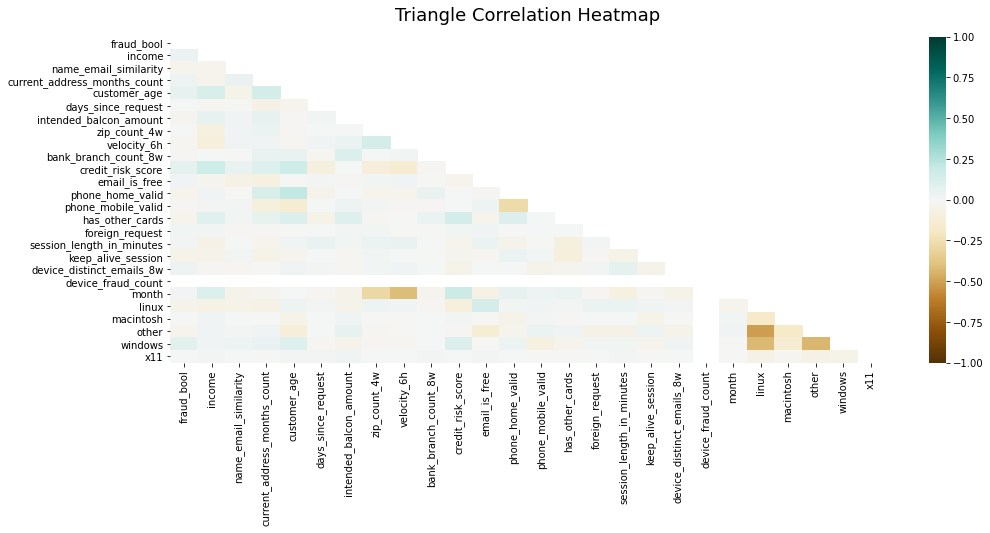

In [8]:
## Triangle Correlation Matrix

plt.figure(figsize=(16, 6))

# define the mask to set the values in the upper triangle to True

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

#df.corr()

## Further EDA

For further Exploratory Data Analysis, a scatterplot between Credit Risk Score and Name to Email Similarity distinguished by fraud vs. not fraud has been produced below.

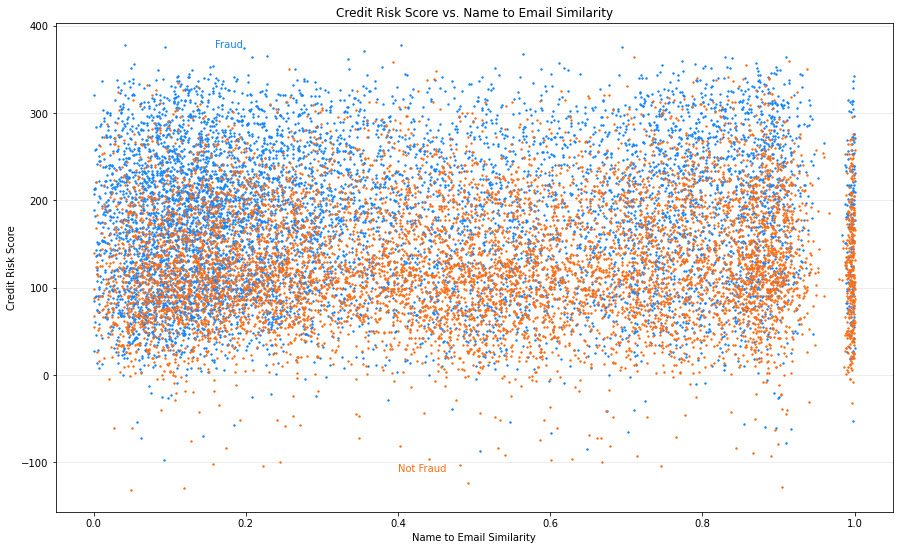

In [9]:
#Scatterplot between Credit Risk Score and Name to Email Similarity distinguished by fraud vs. not fraud

def single_scatter_plot(df, fraud, ax, color):
    """
    This function creates a Credit Risk Score vs. Name to Email 
    similarity plot distinguished by fraud vs. not fraud.
    """
    # Filter data to keep only the data of interest
    _df = df.query("(fraud_bool == @fraud)")
    _df.plot(
        kind = "scatter", x = "name_email_similarity", y = "credit_risk_score", ax = ax, color = color, s = 2
    )

    return ax

fig, ax = plt.subplots(figsize = (15,9))
colors = {"fraud": "#1385ff", "not_fraud": "#ff6d13"}

single_scatter_plot(df_sample, 1, ax, colors["fraud"])
single_scatter_plot(df_sample, 0, ax, colors["not_fraud"])

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

ax.set(
    axisbelow = True,  # Hide the grid behind plot objects
    title = 'Credit Risk Score vs. Name to Email Similarity',
    xlabel = 'Name to Email Similarity',
    ylabel = 'Credit Risk Score',
)

ax.annotate("Fraud", (0.16, 375), color=colors["fraud"])
ax.annotate("Not Fraud", (0.4, -110), color=colors["not_fraud"]);
ax.set_zorder(1)

## Discussion

- It appears that a higher credit score correlates to more fraud. This is shown by more blue dots towards the higher end of the Credit Risk Score axis (further up the y-axis). At first this does not make sense; surely a better credit score would mean that accountholders would be less likely to commit fraud, as they would be individuals or entities that are better off. However, a possible explanation for this trend is that those with higher credit scores may feel that their account(s) wouldn't be under suspicion, and that they could get away with committing fraud, which acts as an incentive for them to have fraudulent accounts.

- Another interesting finding is that name to email similarity is negatively correlated with fraud; that is, names that are more similar to the email address correlate with less fraud. This is shown by more orange dots towards the higher end of the Name to Email Similarity axis (further along the x-axis). This intuitively makes sense as fraudsters would not use an email address that matches their name when committing fraud, in order to conceal their identity.

## Machine Learning and Algorithms

For this analysis, the forward selection algorithm was implemented to find the most significant predictor variables in order. Forward selection is a type of stepwise regression which begins with an empty model and adds in variables one by one. In each forward step, you add the one variable that gives the single best improvement to your model.

Furthermore, k-fold cross-validation resampling procedure was used. Cross-validation is a technique where k is the number of groups that the dataset is split into (hence k-fold), and k-1 of the folds are used as training data and 1 fold is the test data. The 1 fold is then permuted, that is, if we have 5-fold CV, then fold 1 can be the test data, then in the next iteration, fold 2, ... until fold 5 is the test data and the rest are the training data. The purpose of cross-validation is to reduce overfitting, which occurs when the training dataset accuracy is high, but the testing dataset predictions are inaccurate.

The first ML algorithm implemented is logistic regression. Logistic regression is used for classification problems, and it predicts the log-odds, $log \Big(\frac{p}{1-p}\Big)$ of fraud occuring ($p$ is the probility of fraud occuring), based on the coefficients provided by running the regression.

In [10]:
dfnp = df_sample.to_numpy()
dfnp

array([[0.        , 0.9       , 0.14591447, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.4       , 0.12660474, ..., 0.        , 1.        ,
        0.        ],
       [1.        , 0.4       , 0.1797544 , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [1.        , 0.8       , 0.87637568, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.5       , 0.6487778 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.6       , 0.86695758, ..., 0.        , 0.        ,
        0.        ]])

In [11]:
def forward_selection(data, target):
    no_target = data.drop([target], axis=1)
    y = data[target]
    initial_features = no_target.columns.tolist()
    best_features = []
    while (len(best_features))< 15:
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype = str)
        for nc in remaining_features:
            X = no_target[best_features + [nc]]
            kf = model_selection.KFold(n_splits = 4)
            valNp = []
            for train, test in kf.split(X):
                X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
                log_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
                log_model.fit(X_train, y_train)
                valNp.append(metrics.accuracy_score(y_test, log_model.predict(X_test))) 
            meanVal = sum(valNp)/4
            #X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
            #log_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
            #log_model.fit(X_train, y_train)
            new_pval[nc] = meanVal
        maxind = new_pval.tolist().index(max(new_pval.tolist()))
        best_features.append(new_pval.index[maxind])
        coefs = log_model.coef_
    print(coefs)
    return best_features


select_features = forward_selection(df_sample, "fraud_bool")
print(select_features)

[[ 1.23318369  0.00527355 -0.78874847 -1.35023303  0.03367803 -1.06607024
  -1.14820283  1.1670218   0.00326766  0.83356064  0.64055749 -0.00872991
   0.72360769 -0.45241108  0.02686415]]
['windows', 'credit_risk_score', 'keep_alive_session', 'has_other_cards', 'customer_age', 'phone_home_valid', 'name_email_similarity', 'income', 'current_address_months_count', 'device_distinct_emails_8w', 'email_is_free', 'intended_balcon_amount', 'macintosh', 'phone_mobile_valid', 'linux']


In [12]:
select_features

['windows',
 'credit_risk_score',
 'keep_alive_session',
 'has_other_cards',
 'customer_age',
 'phone_home_valid',
 'name_email_similarity',
 'income',
 'current_address_months_count',
 'device_distinct_emails_8w',
 'email_is_free',
 'intended_balcon_amount',
 'macintosh',
 'phone_mobile_valid',
 'linux']

['windows', 'credit_risk_score', 'keep_alive_session', 'has_other_cards', 'customer_age', 'phone_home_valid', 'name_email_similarity', 'income', 'current_address_months_count', 'device_distinct_emails_8w', 'email_is_free', 'intended_balcon_amount', 'macintosh', 'phone_mobile_valid', 'linux']


Text(0, 0.5, 'CV Score')

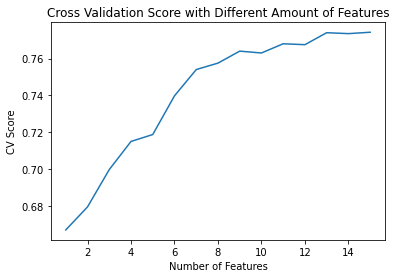

In [13]:
cvVal = []
for i in range(len(select_features)):
    used_features = select_features[0:i+1]
    X = df_sample[used_features]
    y = df_sample["fraud_bool"]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state = 20)
    logistic_model = linear_model.LogisticRegression(solver="lbfgs", max_iter = 10000)
    logistic_model.fit(X_train, y_train)
    cvVal.append(sum(model_selection.cross_val_score(logistic_model, X_test, y_test))/5)
best_score = cvVal.index(max(cvVal))
print(select_features[0:best_score+1])
best_features = select_features[0:best_score+1]

fig, ax = plt.subplots()
ax.plot(list(range(1,len(select_features)+1)), cvVal)
ax.set_title("Cross Validation Score with Different Amount of Features")
ax.set_xlabel("Number of Features")
ax.set_ylabel("CV Score")

Accuracy Score = 76.91666666666667 %


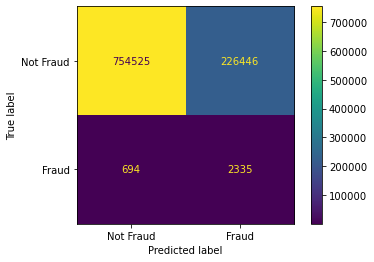

In [14]:
X_train = df_sample[best_features]
y_train = df_sample["fraud_bool"]
X_test = df_test[best_features]
y_test = df_test["fraud_bool"]
logistic_model = linear_model.LogisticRegression(solver="lbfgs", max_iter = 10000)
logistic_model.fit(X_train, y_train)

actual = y_test
predicted = logistic_model.predict(X_test)
metrics.accuracy_score(actual, predicted)

print(f"Accuracy Score = {metrics.accuracy_score(actual, predicted) * 100} %")

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Not Fraud", "Fraud"])

cm_display.plot()
plt.show()

# Logistic Regression with L1 penalty

The L1 regularization adds an L1 penalty equal to the absolute value of the magnitude of coefficients. By doing so, it is a form of regularization, as it limits the size of the coefficients. L1 can yield models with few coefficients, as some can become zero and eliminated. The lasso regression method learned in class uses this method.

In [15]:
def forward_selectionL1(data, target):
    no_target = data.drop([target], axis=1)
    y = data[target]
    initial_features = no_target.columns.tolist()
    best_features = []
    while (len(best_features))< 15:
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype = str)
        for nc in remaining_features:
            X = no_target[best_features + [nc]]
            kf = model_selection.KFold(n_splits = 4)
            valNp = []
            for train, test in kf.split(X):
                X_train, X_test, y_train, y_test = X.loc[train], X.loc[test], y.loc[train], y.loc[test]
                log_model = linear_model.LogisticRegression(penalty = 'l1',solver='liblinear', max_iter=10000)
                log_model.fit(X_train, y_train)
                valNp.append(metrics.accuracy_score(y_test, log_model.predict(X_test))) 
            meanVal = sum(valNp)/4
            #X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)
            #log_model = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
            #log_model.fit(X_train, y_train)
            new_pval[nc] = meanVal
        maxind = new_pval.tolist().index(max(new_pval.tolist()))
        best_features.append(new_pval.index[maxind])
        coefs = log_model.coef_
    print(coefs)
    return best_features

select_features = forward_selectionL1(df_sample, "fraud_bool")
print(select_features)

[[ 1.2239159   0.00526066 -0.79100248 -1.35249773  0.03329618 -1.05810863
  -1.15044951  0.00325015  1.15763213  0.82773788  0.63742459 -0.00874226
   0.68401434 -0.45276964  0.02594219]]
['windows', 'credit_risk_score', 'keep_alive_session', 'has_other_cards', 'customer_age', 'phone_home_valid', 'name_email_similarity', 'current_address_months_count', 'income', 'device_distinct_emails_8w', 'email_is_free', 'intended_balcon_amount', 'macintosh', 'phone_mobile_valid', 'other']


['windows', 'credit_risk_score', 'keep_alive_session', 'has_other_cards', 'customer_age', 'phone_home_valid', 'name_email_similarity', 'current_address_months_count', 'income', 'device_distinct_emails_8w', 'email_is_free', 'intended_balcon_amount', 'macintosh', 'phone_mobile_valid', 'other']


Text(0, 0.5, 'CV Score')

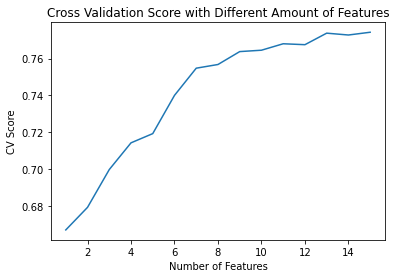

In [16]:
cvVal = []
for i in range(len(select_features)):
    used_features = select_features[0:i+1]
    X = df_sample[used_features]
    y = df_sample["fraud_bool"]
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state = 20)
    logistic_model = linear_model.LogisticRegression(penalty = 'l1', solver="liblinear", max_iter = 10000)
    logistic_model.fit(X_train, y_train)
    cvVal.append(sum(model_selection.cross_val_score(logistic_model, X_test, y_test))/5)
best_score = cvVal.index(max(cvVal))
print(select_features[0:best_score+1])
best_features = select_features[0:best_score+1]

fig, ax = plt.subplots()
ax.plot(list(range(1,len(select_features)+1)), cvVal)
ax.set_title("Cross Validation Score with Different Amount of Features")
ax.set_xlabel("Number of Features")
ax.set_ylabel("CV Score")

Accuracy Score = 76.90254065040651 %


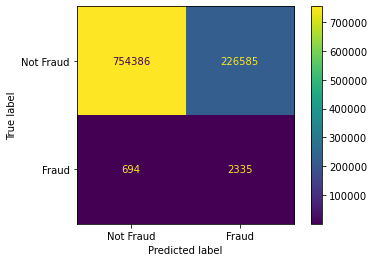

In [17]:
X_train = df_sample[best_features]
y_train = df_sample["fraud_bool"]
X_test = df_test[best_features]
y_test = df_test["fraud_bool"]
logistic_model = linear_model.LogisticRegression(penalty = 'l1', solver="liblinear", max_iter = 10000)
logistic_model.fit(X_train, y_train)

actual = y_test
predicted = logistic_model.predict(X_test)
metrics.accuracy_score(actual, predicted)

print(f"Accuracy Score = {metrics.accuracy_score(actual, predicted) * 100} %")

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Not Fraud", "Fraud"])

cm_display.plot()
plt.show()

## Isolation Forest

After carrying out some independent research, we found the Isolation Forest Algorithm, used for detecting outliers, which is helpful since the fraud cases are essentially "outliers" which we are trying to detect.

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature (essentially a variant of random forests).

The Isolation forest is good for obtaining miniority classes, so will edit the sample such that there are more not fraud than fraud.

Text(0, 0.5, 'Accuracy Score')

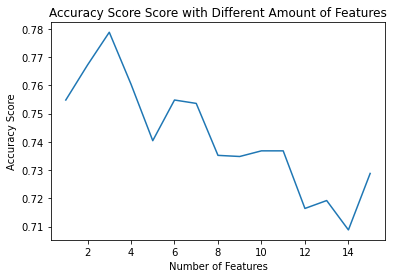

In [18]:
# Isolation forest is good for obtaining miniority classes, so will edit the sample such that there are more not fraud than fraud

import random

random.seed(323)


frsample_if = random.sample(frsample, 2000)

combsample_if = frsample_if + nofrsample

df_fraudsample_if = df.loc[frsample_if]

# Need to shuffle for later cross validation
df_sample_if = pd.concat([df_fraudsample_if, df_notfraudsample])
df_sample_if = df_sample_if.sample(frac=1, random_state=20) # Shuffles the dataset
df_sample_if = df_sample_if.reset_index(drop = True)

cvVal = []
X = df_sample_if.drop(["fraud_bool"], axis=1)
y = df_sample_if["fraud_bool"]
for i in range(1,16):
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state = 20)
    y_testif = y_test.replace([0,1],[1,-1])
    clf = ensemble.IsolationForest(max_samples=1000, random_state=50, max_features = i)
    clf.fit(X_train)
    cvVal.append(metrics.accuracy_score(y_testif, clf.predict(X_test)))
best_score = cvVal.index(max(cvVal))


fig, ax = plt.subplots()
ax.plot(list(range(1,len(select_features)+1)), cvVal)
ax.set_title("Accuracy Score Score with Different Amount of Features")
ax.set_xlabel("Number of Features")
ax.set_ylabel("Accuracy Score")



Accuracy Score = 94.22896341463415 %


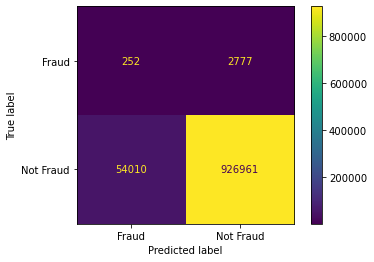

In [19]:
X_train = df_sample_if.drop(["fraud_bool"], axis=1)
X_test = df_test.drop(["fraud_bool"], axis=1)
y_test = df_test["fraud_bool"]
y_testif = y_test.replace([0,1],[1,-1])
clf = ensemble.IsolationForest(max_samples=1000, random_state=50, max_features = best_score + 1)
clf.fit(X_train)
actual = y_testif
predicted = clf.predict(X_test)

print(f"Accuracy Score = {metrics.accuracy_score(actual, predicted) * 100} %")

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Fraud", "Not Fraud"])

cm_display.plot()
plt.show()

## Conclusion and Limitations

From the models run above, credit_risk_score is one of the more significant predictor. It is not enough to know which variables were the most significant, but we must also be able to interpret the coefficients. If we limited ourselves to the first two covariates in the logistic regression model (without the l1 penalty), the coefficient for credit_risk_score is 0.00535808, which suggests that a 1-unit increase in Credit Risk Score correlates to a predicted increase of 0.00535808 in log(odds of fraud), all else kept constant. In a similar way, the rest of the coefficients can be interpretted for logistic regression. 

The model produced an accuracy of 76.92% (an average of the 4 folds) on the test set.

After this, we felt that we could improve on the logistic regression model by adding the l1 penalty. The coefficients of the logistic regression model with the l1 penalty can be interpretted in a similar manner as the coefficients of the logistic regression model without the l1 penalty were.

The model produced an accuracy of 76.89% (an average of the 4 folds) on the test set. This was surprising as we expected to do better with the l1, which perhaps could be a sign of over-regularization.

Lastly, the Isolation Forest model was implemented, and while it is much harder to interpret it, the model produced an accuracy of 94.23% (an average of the 4 folds) on the test set. At first, we may think that the Isolation Forest is much better than the logistic or logistic with l1 penalty, simply because of higher accuracy but the confusion matrix shows that the model tends to produce many false negatives (cases of fraud occuring, which the algorithm predicts to be not fraud).

From the perspective of the bank (which we assume acts rationally and aims to maximize profits), a higher recall than what the Isolation Forest is currently giving would be preferred; the Isolation Forest is allowing to many cases of fraud go unflagged (2777 out of 3029). A silver lining is that precision is high (low false positive rate), which would be good for consumer satisfaction. Furthermore, with the Isolation Forest being a more complex model, we lose some of the interpretability, and often obtain a less parsimonious model.

Through this analysis, we have not only observed the variables that have strong predictive ability, such as "windows", "credit_risk_score", etc., but also the benefits and drawbacks of using the different models.

While the analysis conducted here is thorough, it is far from perfect. There are limitations to the methods used, for example:

- By dropping the categorical variables to avoid higher dimensionality, important information was lost; it is possible that housing_status, employment_status, payment_type, and source had significant ability to predict fraud
- A technique that could have been used in this analysis is Principal Component Analysis (PCA). In short, PCA is a statistical technique that allows you to summarize a large number covariates in terms of a smaller set of "components" on which models can then be run. The benefits are that PCA would have been able to address the high dimensionality and multicollinearity which were concerns in the BAF dataset.
- Perhaps we could have tried to use a Support Vector Classifier or a Neural Network to increase the variety of models used (and it could have yielded better results)

Overall, Steven and I learned a lot throughout ECON 323. Over the semester, we learned about applications of Python programming when it comes to optimization, applied linear algebra, and probability. Through the project, we learned about the nuances of data pre-processing (i.e. justifying dropping variables), and the IsolationForest algorithm.

## Other Notes:

The work was split very evenly, with Sameer providing the write-up and more of the visualizations, and Steven carrying out more of the pre-processing and algorithm/model implementation.

Please note, this project is not related to a thesis for either group member.

This project has also been uploaded to both group members' GitHub.